In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import nltk
from nltk.corpus import gutenberg
nltk.download('punkt')
#nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Niranjan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


In [39]:
#import spacy
#nlp = spacy.load('en_core_web_sm')
#terms_doc = nlp(terms)
terms_lemma = set([tl.lemma_ for tl in terms])

AttributeError: 'str' object has no attribute 'lemma_'

In [37]:
terms_lemma

NameError: name 'terms_lemma' is not defined

In [29]:
X_test_tfidf_csr = X_test_tfidf.tocsr()

In [32]:
type(terms)

list

In [28]:
#print(X_train_tfidf.todense())
#print(X_train_tfidf_csr)
print(terms)
print(X_train_tfidf.shape)
type(X_train_tfidf)

['_has_', '_her_', '_him_', '_home_', '_i_', '_is_', '_me_', '_my_', '_not_', '_one_', '_she_', '_that_', '_then_', '_very_', '_we_', '_you_', 'abbey', 'able', 'abroad', 'absence', 'absent', 'absolutely', 'accept', 'acceptable', 'accepted', 'accepting', 'accompanied', 'accomplished', 'account', 'acknowledge', 'acknowledged', 'acquaintance', 'acquainted', 'acquiescence', 'acquirements', 'act', 'acting', 'activity', 'actually', 'added', 'address', 'addressed', 'addressing', 'admiration', 'admire', 'admired', 'admit', 'admitted', 'advanced', 'advantage', 'advantages', 'adventure', 'advice', 'advise', 'advised', 'affair', 'affected', 'affection', 'affectionate', 'afford', 'afforded', 'affronted', 'afraid', 'afternoon', 'age', 'agitated', 'agitation', 'ago', 'agree', 'agreeable', 'agreed', 'ah', 'aimed', 'air', 'alarm', 'alarming', 'alertness', 'alike', 'alleviation', 'alliance', 'allow', 'allowed', 'allowing', 'alloy', 'allusion', 'aloud', 'alphabets', 'altogether', 'amiable', 'amiss', 'am

scipy.sparse.csr.csr_matrix

In [26]:
type(X_train_tfidf_csr)

scipy.sparse.csr.csr_matrix

In [6]:
#Dimension Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 45.20805737836616
Component 0:
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
" Oh !    0.999286
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.634093
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.574904
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.563595
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elton .       

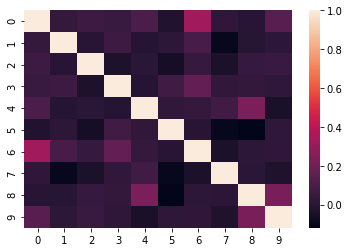

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [7]:
#SENTENCE SIMILARITY
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

In [31]:
#Drill 1: Apply our LSA model to the test set. Does it identify similar sentences for components 0 through 4?
X_test_lsa = lsa.fit_transform(X_test_tfidf)

variance_explained_test=svd.explained_variance_ratio_
total_variance_test = variance_explained_test.sum()
print("Percent variance captured by all components:",total_variance_test*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component_test=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component_test.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 49.364793509459204
Component 0:
" Oh no !    0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
" Oh !       0.999918
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                             0.612531
After tea , Mr . and Mrs . Weston , and Mr . Elton sat down with Mr . Woodhouse to cards .                                                                                                                                  

In [10]:
#Drill 2: Go back up to the code where we originally translated the text from words to numbers. 
#There are a lot of decision-points here, from the stop list to the thresholds for inclusion and exclusion, 
#and many others as well. We also didn't integrate spaCy, and so don't have info on lemmas or Named Entities. 
#Change things up a few times and see how that affects the results of the LSA. 


In [40]:
#how to include lemmas in features
paras_by_component_test.shape

(949, 130)

In [42]:
paras_by_component_test

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
"Mr . Woodhouse had so completely made up his mind to the visit , that in spite of the increasing coldness , he seemed to have no idea of shrinking from it , and set forward at last most punctually with his eldest daughter in his own carriage , with less apparent consciousness of the weather than either of the others ; too full of the wonder of his own going , and the pleasure it was to afford at Randalls to see that it was cold , and too well wrapt up to feel it .",2.460876e-04,1.914086e-01,-8.228000e-03,0.123944,-0.017990,-0.014350,2.453393e-05,0.008324,0.040059,0.054953,...,-0.066928,0.024747,0.103332,-0.003884,0.038669,0.008022,-0.134429,0.040928,0.080860,0.081338
""" Oh !",9.999182e-01,-3.606553e-03,7.229338e-05,0.002022,-0.003116,0.000716,-9.434565e-08,0.002590,-0.000706,-0.002136,...,0.001315,0.000624,-0.001125,-0.000617,-0.000274,0.000710,0.000238,-0.000622,-0.001065,-0.000637
""" Oh no , no !",9.999182e-01,-3.606553e-03,7.229338e-05,0.002022,-0.003116,0.000716,-9.434565e-08,0.002590,-0.000706,-0.002136,...,0.001315,0.000624,-0.001125,-0.000617,-0.000274,0.000710,0.000238,-0.000622,-0.001065,-0.000637
Such was Jane Fairfax ' s history .,2.986689e-04,1.507556e-01,-5.275204e-03,-0.071205,0.105249,0.360376,-1.890514e-06,-0.041247,0.114503,0.347683,...,0.030124,-0.002423,-0.005628,0.021798,-0.002500,0.003674,0.031879,-0.023761,0.021483,-0.045021
""" That has been a good deal the case , my dear ; but not to the degree you mention .",2.502347e-04,1.266379e-01,-2.248601e-03,-0.143548,0.163247,-0.027362,-2.548465e-06,0.253564,-0.279375,0.037502,...,0.034545,0.016766,0.013291,0.072381,-0.135584,-0.005517,0.015744,0.122599,-0.075405,0.051839
""" And I am quite serious too , I assure you ,"" replied Mrs . Elton gaily , "" in resolving to be always on the watch , and employing my friends to watch also , that nothing really unexceptionable may pass us .""",2.823619e-04,2.246627e-01,-7.969677e-03,0.024889,0.032098,0.036543,-2.371427e-05,-0.076350,0.035631,-0.161966,...,0.022301,0.071901,0.039918,0.006736,-0.125370,-0.015581,-0.045628,-0.120324,0.138333,0.040179
""" And here is Mrs . Weston and Mr . Frank Churchill too ! Quite delightful ; so many friends !""",5.127980e-04,4.298566e-01,-1.802797e-02,0.258571,0.132700,0.232030,2.131951e-06,-0.156931,0.083088,-0.439495,...,0.040908,0.012524,0.027758,0.021026,-0.032537,-0.006140,-0.018653,-0.068714,-0.055250,0.021964
""" You may well class the delight , the honour , and the comfort of such a situation together ,"" said Jane , "" they are pretty sure to be equal ; however , I am very serious in not wishing any thing to be attempted at present for me .",3.304606e-03,2.185293e-01,1.641861e-02,-0.181589,0.142429,-0.017876,1.728129e-05,0.324889,0.133431,-0.001447,...,-0.033428,0.123173,0.104205,-0.114624,-0.066429,-0.054362,0.048057,0.023061,0.093998,0.121022
"Harriet , Mr . Elton , and Mr . Knightley , their own especial set , were the only persons invited to meet them ; the hours were to be early , as well as the numbers few ; Mr . Woodhouse ' s habits and inclination being consulted in every thing .",4.982698e-04,4.618363e-01,-2.085022e-02,0.403986,-0.125219,-0.190808,8.642771e-06,0.066517,0.035033,0.190109,...,0.048097,0.087243,0.046936,-0.025192,0.232372,-0.048458,-0.026423,-0.014215,0.052064,-0.043882
""" Oh !",9.999182e-01,-3.606553e-03,7.229338e-05,0.002022,-0.003116,0.000716,-9.434565e-08,0.002590,-0.000706,-0.002136,...,0.001315,0.000624,-0.001125,-0.000617,-0.000274,0.000710,0.000238,-0.000622,-0.001065,-0.000637
